In [1]:
import pandas as pd; import numpy as np; import yfinance as yf; from gym import Env; from datetime import datetime
from matplotlib import pyplot as plt
from scipy.optimize import linprog

c:\Users\berge\miniconda3\envs\env_hugo\lib\site-packages\yfinance\base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


# Get Mkt data

In [2]:
start_dt = datetime(2021,1,2)
end_dt = datetime(2023,12,31)
spx = yf.download( "^GSPC", start=start_dt, end=end_dt )[['Close']]
cac = yf.download("^FCHI", start=start_dt, end=end_dt)[['Close']]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
data = pd.concat([spx, cac], axis=1, join='inner').ffill().pct_change()
data.columns = ['SPX Index', 'CAC Index']
points, assets = data.shape

# Create pseudo portfolio holdings

In [4]:
rndstate = np.random.RandomState(1)
holdings = (rndstate.random((points,2)) - .5) / 5
holdings = (1+holdings).cumprod(axis=0)
holdings = holdings * (0.6, 0.4)
holdings /= holdings.sum(axis=1)[:,None]

nav = (data * holdings).sum(axis=1)
nav_value = 1000000*(1+nav).cumprod()
nav_value

Date
2021-01-04    1.000000e+06
2021-01-05    1.002159e+06
2021-01-06    1.010516e+06
2021-01-07    1.022053e+06
2021-01-08    1.028136e+06
                  ...     
2023-12-21    1.278407e+06
2023-12-22    1.278414e+06
2023-12-27    1.280162e+06
2023-12-28    1.275247e+06
2023-12-29    1.275581e+06
Length: 748, dtype: float64

In [5]:
data_value = 1000000*(1+data).cumprod()
data_value.iloc[0,:] = [1000000, 1000000]
data_value

,SPX Index,CAC Index
Date,,
2021-01-04,1.000000e+06,1.000000e+06
2021-01-05,1.007083e+06,9.956414e+05
2021-01-06,1.012833e+06,1.007450e+06
2021-01-07,1.027871e+06,1.014473e+06
2021-01-08,1.033516e+06,1.021099e+06
...,...,...
2023-12-21,1.282680e+06,1.354706e+06
2023-12-22,1.284809e+06,1.354245e+06
2023-12-27,1.292092e+06,1.354782e+06


# Optimization

In [209]:
init_w = np.array([.5, .5])

dim_pb, dim_assets = data_value.shape
dim_pb -= 1

# Lin vect
vect = np.array([ ([0 for k in range(dim_assets)]+[1, 1])*dim_pb ]).flatten()

# Ineq cstr
# Init
matr_init_cstr = np.zeros((1, (dim_assets+2)*dim_pb ))
matr_init_cstr[0,0:dim_assets] = data_value.iloc[1,:].values
vect_init_cstr = np.array([1001362.0134676425])
# Eq cstr
matr_eq_cstr = np.zeros((dim_pb-1, (dim_assets+2)*dim_pb ))
for k in range(dim_pb-1):
    matr_eq_cstr[k,k*(2+dim_assets):(k+1)*(dim_assets+2)-2] = - data_value.iloc[k+2].values
    matr_eq_cstr[k,k*(2+dim_assets)+4:(k+1)*(dim_assets+2)+2] = data_value.iloc[k+2].values

vect_eq_cstr = np.zeros(dim_pb-1)
# TE eq
matr_te_cstr = np.zeros((dim_pb, (dim_assets+2)*dim_pb ))
for k in range(dim_pb):
    matr_te_cstr[k,k*(2+dim_assets):(k+1)*(dim_assets+2)] = np.hstack([data_value.iloc[k].values, np.array([-1, 1]) ])
vect_te_cstr = nav_value.values[1:]

# Last eq
matr_last_eq = np.zeros(( 1, (dim_assets+2)*dim_pb ))
matr_last_eq[0,-8:-2] = [ -1., -1., 0., 0., 1., 1. ]
vect_last_eq = np.zeros(1)

# Turnover constraint
matr_turnover_constraint = np.zeros((2*(dim_pb-1)*dim_assets, (dim_assets+2)*dim_pb ))

i = 0
for j in range(dim_pb-1):
    for k in range(dim_assets):
        matr_turnover_constraint[i, j*(dim_assets+2) + k] = -1
        matr_turnover_constraint[i, (j+1)*(dim_assets+2) + k] = 1
        matr_turnover_constraint[i+1, j*(dim_assets+2) + k] = 1
        matr_turnover_constraint[i+1, (j+1)*(dim_assets+2) + k] = -1
        i+=2

vect_turnover = np.array([.025, .025]*(dim_pb-1)*dim_assets)

# Bnds
bnds = np.array([
    [0., 1.],
    [0., 1.],
    [0., np.inf],
    [0., np.inf]
    ]*dim_pb)

# FINAL

EQ_MATR = np.vstack([ matr_eq_cstr, matr_te_cstr, matr_last_eq ])
EQ_VECT = np.hstack([ vect_eq_cstr, vect_te_cstr, vect_last_eq ])
INEQ_MATR = np.vstack([matr_init_cstr, matr_turnover_constraint])
INEQ_VECT = np.hstack([vect_init_cstr, vect_turnover])
BOUNDS = bnds
VECT = vect

In [210]:
res = linprog(VECT, A_ub=INEQ_MATR, b_ub=INEQ_VECT, A_eq=EQ_MATR, b_eq=EQ_VECT, bounds=BOUNDS, method='highs', options={'mip_rel_gap': 1e-11})

In [221]:
result = res.x
weights  = []
for k in range(dim_pb):
    weights.append(result[k*4:(k+1)*4-2].tolist())

weights = np.array(weights)
weights = ((weights*data_value.iloc[1:,:]) / (weights*data_value.iloc[1:,:]).sum(axis=1)[:,None])
weights

C:\Users\berge\AppData\Local\Temp\ipykernel_16912\1580903634.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  weights = ((weights*data_value.iloc[1:,:]) / (weights*data_value.iloc[1:,:]).sum(axis=1)[:,None])


,SPX Index,CAC Index
Date,,
2021-01-05,0.346650,0.653350
2021-01-06,0.370180,0.629820
2021-01-07,0.396836,0.603164
2021-01-08,0.421437,0.578563
2021-01-11,0.446575,0.553425
...,...,...
2023-12-21,0.187844,0.812156
2023-12-22,0.163040,0.836960
2023-12-27,0.138539,0.861461


<Axes: xlabel='Date'>

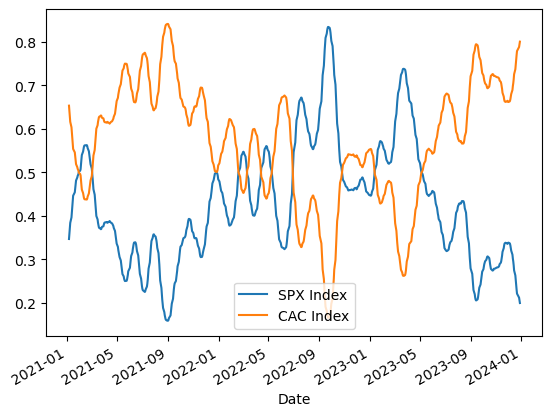

In [223]:
weights.rolling(20, min_periods=1).mean().plot()

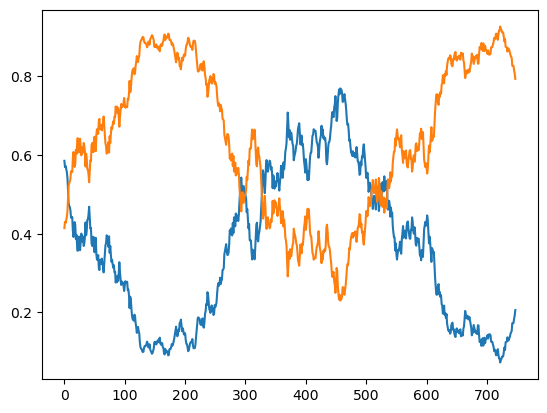

In [225]:
plt.plot(holdings)

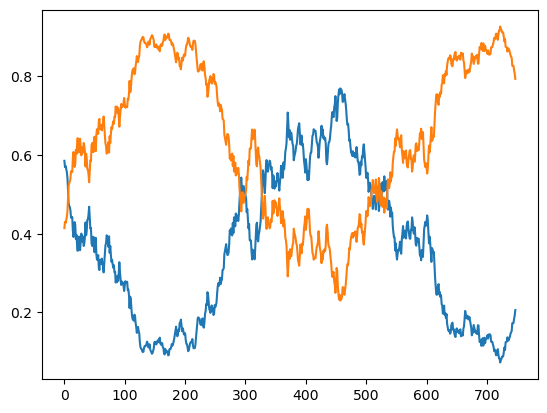

C:\Users\berge\AppData\Local\Temp\ipykernel_16912\1580903634.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  weights = ((weights*data_value.iloc[1:,:]) / (weights*data_value.iloc[1:,:]).sum(axis=1)[:,None])


,SPX Index,CAC Index
Date,,
2021-01-05,0.346650,0.653350
2021-01-06,0.370180,0.629820
2021-01-07,0.396836,0.603164
2021-01-08,0.421437,0.578563
2021-01-11,0.446575,0.553425
...,...,...
2023-12-21,0.187844,0.812156
2023-12-22,0.163040,0.836960
2023-12-27,0.138539,0.861461


In [201]:
plt.plot(  (weights * data_value).sum(axis=1) )
plt.plot( nav_value )

ValueError: Unable to coerce to DataFrame, shape must be (748, 2): given (747, 2)

In [170]:
holdings

array([[0.58555227, 0.41444773],
       [0.56969569, 0.43030431],
       [0.57258104, 0.42741896],
       ...,
       [0.18414344, 0.81585656],
       [0.19229494, 0.80770506],
       [0.20615912, 0.79384088]])

In [169]:
weights/weights.sum(axis=1)[:,None]

array([[0.5       , 0.5       ],
       [0.33391752, 0.66608248],
       [0.36375935, 0.63624065],
       ...,
       [0.13724384, 0.86275616],
       [0.16855327, 0.83144673],
       [0.16855327, 0.83144673]])

In [171]:
(abs(holdings - weights/weights.sum(axis=1)[:,None])).mean(axis=0)

array([0.15262505, 0.15262505])